In [20]:
import re
import random
import pandas as pd
import hashlib

In [21]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate', 'Jane Eyre, Bronte']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [22]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Pandas,191.610527,19.161053,26.635335,10
DAX,361.853240,40.205916,112.577657,9
"Jane Eyre, Bronte",370.566388,52.938055,124.192753,7
Logging in Python,545.202289,60.578032,198.198526,9
Microsoft Purview,661.927660,13.238553,25.486694,50
Azure AD Authentication,971.078923,80.923244,148.082229,12
Azure Functions + PP365,1072.621790,67.038862,228.465665,16
TSQL,1142.044133,47.585172,144.485635,24
Azure VM + Developer,1357.549060,39.927914,124.473843,34
Terraform,1515.975272,84.220848,379.708583,18


# Histogram

sum of ages: ~46820.28


<Axes: >

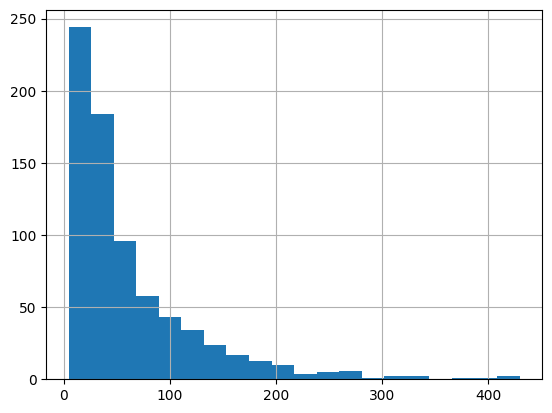

In [23]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~46820.28


<Axes: >

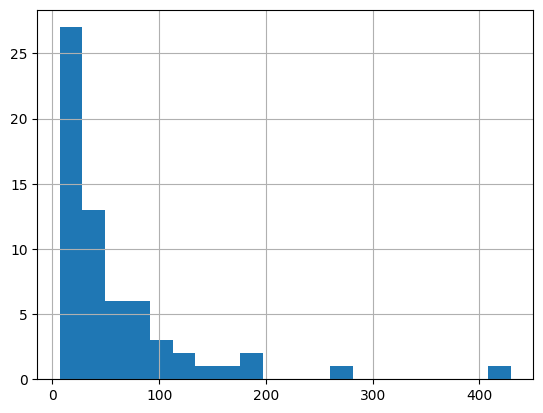

In [39]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure Developer Associate']['age'].hist(bins=20)

# Completely Random Shuffle

In [25]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [26]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [27]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [28]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [29]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [30]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [31]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [32]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [33]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [34]:
n = 3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

if existing_cards['age'].sum() > 0:
    existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 747
Total card age: 46820.28


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold,neg_age
21,Azure Developer Associate,You plan to generate a shared access signature...,d6a7ed20d7e17dc1c61b36d373e2eb48,429.462282,58.937573,-429.462282,3713.067099,0.674008,0,0,-429.462282
22,Azure Developer Associate,The delete rule action supports both block blo...,d08c888b697fbcdd868eafe894ecc100,184.105680,58.937573,-429.462282,3713.067099,0.674008,3,0,-184.105680
23,Azure Developer Associate,To mount multiple volumes in an Azure Containe...,9fd57a268e9ea38e54cab495b7ad7cd5,121.428518,58.937573,-429.462282,3713.067099,0.674008,6,0,-121.428518
24,Azure Developer Associate,You are a developing a serverless API using Az...,e0ca187d857e4165727517c2e4b81dd6,97.385272,58.937573,-429.462282,3713.067099,0.674008,9,0,-97.385272
280,Azure Developer Associate,The .NET SDK for Azure Cosmos DB for NoSQL shi...,6b266a08728213cd70fbb1cf8e56b84d,83.969523,58.937573,-429.462282,3713.067099,0.674008,12,0,-83.969523
281,Azure Developer Associate,You can specify external volumes to mount with...,6c6791d68279c356e8d09ea0ab3b7d9c,75.823132,58.937573,-429.462282,3713.067099,0.674008,15,0,-75.823132
532,Azure Developer Associate,Configuration data stored in an App Configurat...,22293608d8680b7f657f335dbf029202,63.784980,58.937573,-429.462282,3713.067099,0.674008,18,0,-63.784980
28,Azure Developer Associate,"By default, Azure Container Instances are stat...",b79b7a7b287b05e4b30b04a007b89f3d,60.217637,58.937573,-429.462282,3713.067099,0.674008,21,0,-60.217637
284,Azure Developer Associate,You have an Azure web app that occasionally ex...,4e7adf4fdcee8e7ca9084be4ce136544,46.784490,58.937573,-429.462282,3713.067099,0.674008,24,0,-46.784490
285,Azure Developer Associate,There are two common ways to deploy a multi-co...,6bd2c2d6cff98bb775782969703f3d77,45.653003,58.937573,-429.462282,3713.067099,0.674008,27,0,-45.653003


## Card Count

In [35]:
# n=5
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [36]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [37]:
if existing_cards.age.sum() < 0:
    asc = True
else: asc = False
existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold,neg_age
21,Azure Developer Associate,You plan to generate a shared access signature...,d6a7ed20d7e17dc1c61b36d373e2eb48,429.462282,58.937573,-429.462282,3713.067099,0.674008,0,0,-429.462282
2,Azure Private DNS,DNS Proxy\nDefinition: A feature that allows D...,7afb51ca2c17c5d23a40fbb536b4ef56,414.192004,80.386806,-414.192004,1527.349321,0.229890,0,0,-414.192004
9,FSLogix,Q: How does FSLogix Profile Container enhance ...,6e14a79eafeac794c566a2f5be07a49e,404.024859,88.979995,-404.024859,3025.319839,0.532765,0,0,-404.024859
42,Terraform,terraform validate:\nA CLI command that checks...,036e232f01695e400da5847ea8babd0d,379.708583,84.220848,-379.708583,1515.975272,0.020591,0,0,-379.708583
48,Python,Q:\nHow can you obtain command-line arguments ...,6a00d6335b8d45302a333e507237865b,338.706664,55.992441,-338.706664,3359.546459,0.877151,0,0,-338.706664
68,Asynchronous Python,asyncio.gather()\nRuns multiple asynchronous P...,88e88ee301ac734f3b1f136e405d3cfd,323.837272,87.463949,-323.837272,3586.021929,0.415104,0,0,-323.837272
82,C# Basics,What’s the difference between delegates and ev...,aafda82832da4aaff149c8153e06fc0a,318.624753,72.973938,-318.624753,2262.192087,0.620017,0,0,-318.624753
93,Azure DevOps Pipelines,"In Azure DevOps, what is the use of the strate...",22834b179fc5b8002c41682d03a4bac2,302.596676,89.539039,-302.596676,2148.936948,0.807249,0,0,-302.596676
265,FSLogix,"Cloud Cache uses the concept of a proxy file, ...",78203bab9238f47ee752697bba4135a5,296.203239,88.979995,-404.024859,3025.319839,0.532765,1,1,-296.203239
323,Asynchronous Python,asyncio.wait_for()\nRuns a coroutine with a ti...,0ccadcbce46e58eb4de4907f7e86cbf9,278.612324,87.463949,-323.837272,3586.021929,0.415104,1,1,-278.612324


In [38]:
existing_cards['age'].mean()

62.67775335838473